<a href="https://colab.research.google.com/github/paulbaitalik/Pyspark/blob/main/Using_Machine_Learning_techniques_with_PySpark_Predicting_Early_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Spark Install

In [ ]:
!apt-get update > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
#mounting drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data

In [ ]:
#loading dataset 
df = spark.read.csv('/content/drive/MyDrive/CVS Excel Files /BigML_Heart_Dataset.csv', inferSchema=True,header=True)

In [ ]:
df.show(5)

+------+----+------------+-------------+---------------+-----+--------+
|gender| age|hypertension|heart_disease|smoking_history|  BMI|diabetes|
+------+----+------------+-------------+---------------+-----+--------+
|Female|80.0|           0|            1|          never|25.19|       0|
|Female|54.0|           0|            0|           null| null|       0|
|  Male|28.0|           0|            0|          never| null|       0|
|Female|36.0|           0|            0|        current|23.45|       0|
|  Male|76.0|           1|            1|        current|20.14|       0|
+------+----+------------+-------------+---------------+-----+--------+
only showing top 5 rows



# Data wrangling 


In [ ]:
print((df.count(),len(df.columns)))

(100000, 7)


In [ ]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- diabetes: integer (nullable = true)



In [ ]:
#descriptive analysis 
df.describe().show()

+-------+------+-----------------+------------------+------------------+---------------+------------------+-------------------+
|summary|gender|              age|      hypertension|     heart_disease|smoking_history|               BMI|           diabetes|
+-------+------+-----------------+------------------+------------------+---------------+------------------+-------------------+
|  count|100000|           100000|            100000|            100000|          64184|             74556|             100000|
|   mean|  null|41.88585600000013|           0.07485|           0.03942|           null|27.321028891034764|              0.085|
| stddev|  null|22.51683987161704|0.2631504702289171|0.1945930169980986|           null| 7.686295651045002|0.27888308976661896|
|    min|Female|             0.08|                 0|                 0|        current|             10.01|                  0|
|    max| Other|             80.0|                 1|                 1|    not current|             95.

In [ ]:
#diabetic and non-diabetic count 
df.groupBy('diabetes').count().show()

+--------+-----+
|diabetes|count|
+--------+-----+
|       1| 8500|
|       0|91500|
+--------+-----+



# EDA

100000


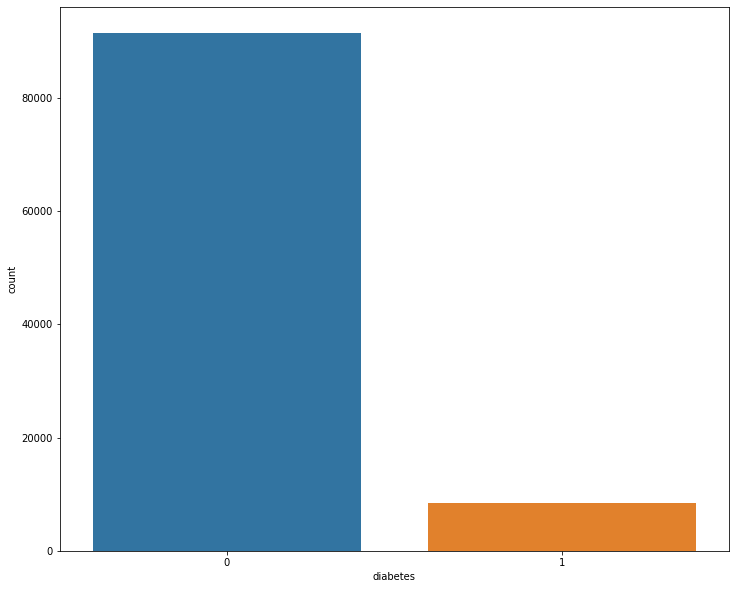

In [ ]:
# it is a imbalance dataset let visualize that 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_pd = df.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='diabetes', data=df_pd, order=df_pd['diabetes'].value_counts().index)

In [ ]:
# create DataFrame as a temporary view
df.createOrReplaceTempView('table')

In [ ]:
### EDA using spark.sql

In [ ]:
#group by gender 
spark.sql("SELECT gender, count(gender) as count_gender, count(gender)*100/sum(count(gender)) over() \
 as percent  FROM table GROUP BY gender").show()

+------+------------+-------+
|gender|count_gender|percent|
+------+------------+-------+
|Female|       58552| 58.552|
| Other|          18|  0.018|
|  Male|       41430|  41.43|
+------+------------+-------+



In [ ]:
#group by gender having diabetes 
spark.sql("SELECT gender, count(gender), (COUNT(gender) * 100.0) /(SELECT count(gender) FROM table ) as \
percentage FROM table WHERE diabetes = '1'  GROUP BY gender").show()

+------+-------------+----------------+
|gender|count(gender)|      percentage|
+------+-------------+----------------+
|Female|         4461|4.46100000000000|
|  Male|         4039|4.03900000000000|
+------+-------------+----------------+



In [ ]:
#group by gender having heart disease 
spark.sql("SELECT gender, count(gender), (COUNT(gender) * 100.0) /(SELECT count(gender) FROM table ) as \
percentage FROM table WHERE heart_disease = '1'  GROUP BY gender").show()

+------+-------------+----------------+
|gender|count(gender)|      percentage|
+------+-------------+----------------+
|Female|         1562|1.56200000000000|
|  Male|         2380|2.38000000000000|
+------+-------------+----------------+



In [ ]:
#group by gender having hypertension 
spark.sql("SELECT gender, count(gender), (COUNT(gender) * 100.0) /(SELECT count(gender) FROM table ) as \
percentage FROM table WHERE hypertension = '1'  GROUP BY gender").show()

+------+-------------+----------------+
|gender|count(gender)|      percentage|
+------+-------------+----------------+
|Female|         4197|4.19700000000000|
|  Male|         3288|3.28800000000000|
+------+-------------+----------------+



In [ ]:
#count of different types of smoker
df.groupBy('smoking_history').count().show()

+---------------+-----+
|smoking_history|count|
+---------------+-----+
|    not current| 6447|
|           null|35816|
|         former| 9352|
|        current| 9286|
|          never|35095|
|           ever| 4004|
+---------------+-----+



In [ ]:
#Age vs Diabetes 
spark.sql("SELECT age, count(age) as age_count FROM table WHERE diabetes == 1 GROUP BY age ORDER BY age_count DESC").show()

+----+---------+
| age|age_count|
+----+---------+
|80.0|     1024|
|62.0|      258|
|61.0|      250|
|66.0|      241|
|67.0|      236|
|65.0|      234|
|57.0|      233|
|59.0|      216|
|60.0|      213|
|64.0|      211|
|68.0|      208|
|69.0|      206|
|58.0|      205|
|63.0|      202|
|55.0|      201|
|71.0|      192|
|54.0|      191|
|56.0|      187|
|74.0|      184|
|70.0|      183|
+----+---------+
only showing top 20 rows



In [ ]:
#count of diabetic patients over age 50 
df.filter((df['diabetes'] == 1) & (df['age'] > '50')).count()


6650

# Data Preprocessing

In [ ]:
#checking null values
df.toPandas().isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history    35816
BMI                25444
diabetes               0
dtype: int64

In [ ]:
# fill in missing values for smoking_history
train_f = df.na.fill('No Info', subset=['smoking_history'])
# fill in miss values for BMI with mean
from pyspark.sql.functions import mean
mean = train_f.select(mean(train_f['BMI'])).collect()
mean_bmi = mean[0][0]
train_f = train_f.na.fill(mean_bmi,['BMI'])

In [ ]:
train_f.describe().show()

+-------+------+-----------------+------------------+------------------+---------------+------------------+-------------------+
|summary|gender|              age|      hypertension|     heart_disease|smoking_history|               BMI|           diabetes|
+-------+------+-----------------+------------------+------------------+---------------+------------------+-------------------+
|  count|100000|           100000|            100000|            100000|         100000|            100000|             100000|
|   mean|  null|41.88585600000013|           0.07485|           0.03942|           null|27.321028891031315|              0.085|
| stddev|  null|22.51683987161704|0.2631504702289171|0.1945930169980986|           null|  6.63678340151884|0.27888308976661896|
|    min|Female|             0.08|                 0|                 0|        No Info|             10.01|                  0|
|    max| Other|             80.0|                 1|                 1|    not current|             95.

In [ ]:
train_f.toPandas().isnull().sum()

gender             0
age                0
hypertension       0
heart_disease      0
smoking_history    0
BMI                0
diabetes           0
dtype: int64

In [ ]:
train_f.dtypes

[('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('smoking_history', 'string'),
 ('BMI', 'double'),
 ('diabetes', 'int')]

# One-Hot Encoding

In [ ]:
# we have two categorical varibales gender and smoking history 

In [ ]:
from pyspark.ml.feature import (VectorAssembler,OneHotEncoder,
                                StringIndexer)

In [ ]:
# indexing all categorical columns in the dataset
from pyspark.ml.feature import StringIndexer
indexer1 = StringIndexer(inputCol="gender", outputCol="genderIndex")
indexer2 = StringIndexer(inputCol="smoking_history", outputCol="smoking_statusIndex")

In [ ]:
# Doing one hot encoding of indexed data
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=["genderIndex","smoking_statusIndex"],
                                 outputCols=["genderVec","smoking_statusVec"])

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'BMI',
 'smoking_statusVec'],outputCol='features')

# Train-Test Split 

In [ ]:
# splitting training and validation data
train_data,val_data = train_f.randomSplit([0.7,0.3])
print(train_data.count())
print(val_data.count())

69937
30063


# Logistic Regression Model Pipeline 

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol='diabetes',featuresCol='features',maxIter=5)

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, encoder, assembler,lr])
# training model pipeline with data
model = pipeline.fit(train_data)

In [ ]:
lr_predictions=model.transform(val_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_evaluator = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="accuracy")
lr_acc=acc_evaluator.evaluate(lr_predictions)

print('A Logistic Regression algorithm had an accuracy of: {0:2.2f}%'.format(lr_acc*100))


A Logistic Regression algorithm had an accuracy of: 91.47%


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator = BinaryClassificationEvaluator(labelCol='diabetes')

# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(lr_predictions, {evaluator.metricName: "areaUnderROC"})
#auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
#print("Area under PR Curve: {:.4f}".format(auprc))


Area under ROC Curve: 0.7921


# Random Forest Pipeline

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'diabetes')

In [ ]:
from pyspark.ml import Pipeline
pipeline1 = Pipeline(stages=[indexer1, indexer2, encoder, assembler,rf])
# training model pipeline with data
model = pipeline1.fit(train_data)

In [ ]:
rf_predictions=model.transform(val_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_evaluator = MulticlassClassificationEvaluator(labelCol="diabetes", predictionCol="prediction", metricName="accuracy")
rf_acc=acc_evaluator.evaluate(rf_predictions)

print('A Random Forest algorithm had an accuracy of: {0:2.2f}%'.format(lr_acc*100))

A Random Forest algorithm had an accuracy of: 91.47%


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator = BinaryClassificationEvaluator(labelCol='diabetes')

# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})
#auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
#print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.8225


# Gradient Boost Model Pipeline

In [ ]:
# next we checkout gradient boosting trees

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol='diabetes',featuresCol='features')

In [ ]:
pipeline_1 = Pipeline(stages=[indexer1, indexer2, encoder, assembler,gbt])

In [ ]:
model = pipeline_1.fit(train_data)

In [ ]:
gbt_predictions = model.transform(val_data)

In [ ]:
gbt_acc = acc_evaluator.evaluate(gbt_predictions)

In [ ]:
print('Gradient Boost algorithm had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))

Gradient Boost algorithm had an accuracy of: 91.73%


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator = BinaryClassificationEvaluator(labelCol='diabetes')

# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})
#auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
#print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.8368
